In [ ]:
!pip install transformers datasets accelerate
!pip install evaluate
!pip install peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00


Phase 1: Establish the DistilBERT Baseline

In [ ]:
import torch
import numpy as np
import pandas as pd
import time
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import evaluate


In [ ]:
MODEL_NAME = "distilbert-base-uncased"
TASK = "sst2"
NUM_LABELS = 2
LEARNING_RATE = 2e-5
BATCH_SIZE = 16
NUM_EPOCHS = 3
OUTPUT_DIR = "./baseline_results"


In [ ]:
print(f"Loading dataset: {TASK}")
raw_datasets = load_dataset("glue", TASK)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(examples["sentence"], truncation=True, padding=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets = tokenized_datasets.remove_columns(["sentence", "idx"])


Loading dataset: sst2


Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [ ]:
train_dataset = tokenized_datasets["train"].shuffle(seed=42)
eval_dataset = tokenized_datasets["validation"]
train_dataset.set_format("torch")
eval_dataset.set_format("torch")


In [ ]:
metric = evaluate.load("glue", TASK)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)


In [ ]:
print(f"Loading base model: {MODEL_NAME}")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading base model: distilbert-base-uncased


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


/tmp/ipython-input-4043023761.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
start_time = time.time()
trainer.train()
end_time = time.time()

training_time_min = (end_time - start_time) / 60


Epoch,Training Loss,Validation Loss,Accuracy
1,0.184000,0.268835,0.908257
2,0.128000,0.338121,0.909404
3,0.089100,0.418129,0.903670


In [ ]:
results = trainer.evaluate()
baseline_accuracy = results['eval_accuracy']

print("\nBaseline Results Summary")
print(f"Total Parameters: {model.num_parameters()}")
print(f"Validation Accuracy: {baseline_accuracy:.4f}")



Baseline Results Summary
Total Parameters: 66955010
Validation Accuracy: 0.9094


In [ ]:
baseline_results = [{
    'Method': 'Full Baseline Fine-Tuning',
    'Iteration': 1,
    'Total_Parameters': model.num_parameters(),
    'Trainable_Parameters': model.num_parameters(),
    'Validation_Accuracy': baseline_accuracy,
    'Training_Time_min': training_time_min,
}]
baseline_df_single = pd.DataFrame(baseline_results)
baseline_df_single.to_csv("baseline_training_results.csv", index=False)

print("Baseline results saved to baseline_training_results.csv")


Baseline results saved to baseline_training_results.csv


In [ ]:
with open("baseline_results_summary.txt", "w") as f:
    f.write(f"Model: {MODEL_NAME}\n")
    f.write(f"Total Parameters: {model.num_parameters()}\n")
    f.write(f"Validation Accuracy: {baseline_accuracy:.4f}\n")

print("Summary saved to baseline_results_summary.txt")


Summary saved to baseline_results_summary.txt


Fine tuning using LoRA

In [ ]:
import torch
import numpy as np
import evaluate
import time

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

from peft import LoraConfig, get_peft_model, TaskType


In [ ]:
MODEL_NAME = "distilbert-base-uncased"
TASK = "sst2"
NUM_LABELS = 2
MANUAL_SEED = 42

# Training
LEARNING_RATE = 5e-4
BATCH_SIZE = 16
NUM_EPOCHS = 3

# LoRA
LORA_R = 16
LORA_ALPHA = 32
LORA_DROPOUT = 0.1
TARGET_MODULES = ["q_lin", "v_lin", "out_lin"]

OUTPUT_DIR = "./lora_results_final_fix"


In [ ]:
LORA_CONFIG = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type=TaskType.SEQ_CLS,
    target_modules=TARGET_MODULES,
)


In [ ]:
print(f"Loading dataset: {TASK}")
raw_datasets = load_dataset("glue", TASK)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


Loading dataset: sst2


In [ ]:
def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        truncation=True,
        padding=True
    )

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets = tokenized_datasets.remove_columns(["sentence", "idx"])


Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [ ]:
train_dataset = tokenized_datasets["train"].shuffle(seed=MANUAL_SEED)
eval_dataset = tokenized_datasets["validation"]

train_dataset.set_format("torch")
eval_dataset.set_format("torch")


In [ ]:
metric = evaluate.load("glue", TASK)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(
        predictions=predictions,
        references=labels
    )


In [ ]:
print(f"\nLoading base model: {MODEL_NAME}")
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Loading base model: distilbert-base-uncased


In [ ]:
print("\nApplying Mandatory Parameter Freeze")

for param in model.parameters():
    param.requires_grad = False

print(
    f"Trainable parameters after manual freeze: "
    f"{model.num_parameters(only_trainable=True)}"
)



Applying Mandatory Parameter Freeze
Trainable parameters after manual freeze: 0


In [ ]:
lora_model = get_peft_model(model, LORA_CONFIG)

print("\nTrainable Parameters After LoRA Injection")
lora_model.print_trainable_parameters()

print(f"Total Model Parameters: {model.num_parameters()}")



Trainable Parameters After LoRA Injection
trainable params: 1,034,498 || all params: 67,989,508 || trainable%: 1.5216
Total Model Parameters: 67989508


In [ ]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
    seed=MANUAL_SEED,
)


In [ ]:
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


/tmp/ipython-input-627676296.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
print("\nStarting LoRA Fine-Tuning")
trainer.train()



Starting LoRA Fine-Tuning


Epoch,Training Loss,Validation Loss,Accuracy
1,0.225500,0.319693,0.878440
2,0.172900,0.321445,0.896789
3,0.124600,0.379389,0.900229


TrainOutput(global_step=12630, training_loss=0.18980844668330224, metrics={'train_runtime': 873.0543, 'train_samples_per_second': 231.425, 'train_steps_per_second': 14.466, 'total_flos': 3455977671555504.0, 'train_loss': 0.18980844668330224, 'epoch': 3.0})

In [ ]:
results = trainer.evaluate()
lora_accuracy = results["eval_accuracy"]

In [ ]:
print("\nLoRA Results Summary")
print(f"Total Model Parameters: {model.num_parameters()}")
print(f"Trainable LoRA Parameters: {lora_model.num_parameters(only_trainable=True)}")
print(f"Validation Accuracy: {lora_accuracy:.4f}")



LoRA Results Summary
Total Model Parameters: 67989508
Trainable LoRA Parameters: 1034498
Validation Accuracy: 0.9002


In [ ]:
with open("lora_results_summary.txt", "w") as f:
    f.write(
        f"Model: {MODEL_NAME} with LoRA\n"
        f"LoRA r={LORA_R}, alpha={LORA_ALPHA}, dropout={LORA_DROPOUT}\n"
        f"Target Modules: {TARGET_MODULES}\n"
        f"Learning Rate: {LEARNING_RATE}\n"
        f"Trainable LoRA Parameters: "
        f"{lora_model.num_parameters(only_trainable=True)}\n"
        f"Validation Accuracy: {lora_accuracy:.4f}\n"
    )

print("Results saved to lora_results_summary.txt")


Results saved to lora_results_summary.txt


Results Comparison

In [ ]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt

In [ ]:
baseline_df = pd.read_csv("baseline_training_results_single_run.csv")
BASELINE_TRAINABLE = baseline_df["Trainable_Parameters"].values[0]
BASELINE_ACCURACY = baseline_df["Validation_Accuracy"].values[0]
BASELINE_TIME_MINUTES = baseline_df["Training_Time_min"].values[0]
TOTAL_PARAMS = baseline_df["Total_Parameters"].values[0]
with open("lora_results_summary.txt", "r") as f:
    lora_txt = f.read()
LORA_TRAINABLE = int(re.search(r"Trainable LoRA Parameters: (\d+)", lora_txt).group(1))
LORA_ACCURACY = float(re.search(r"Validation Accuracy: ([\d.]+)", lora_txt).group(1))
time_match = re.search(r"Training Time \(minutes\): ([\d.]+)", lora_txt)

In [ ]:
def plot_time_comparison():
    methods = ['Baseline (Full FT)', 'LoRA (PEFT)']
    times = [BASELINE_TIME_MINUTES, LORA_TIME_MINUTES]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(methods, times, color=['royalblue', 'red'])
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, f'{yval:.2f} min',
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.title('Training Time Comparison (3 Epochs)', fontsize=16)
    plt.ylabel('Training Time (Minutes)', fontsize=14)
    plt.ylim(0, max(times) + 5)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig("results/training_time_comparison.png", dpi=300)
    plt.show()


Efficiency Summary
Baseline Time: 22.18 min | Params: 66.96M | Accuracy: 0.9083
LoRA Time:     14.23 min | Params: 1.034M | Accuracy: 0.9002
LoRA reduced training time by: 7.95 minutes


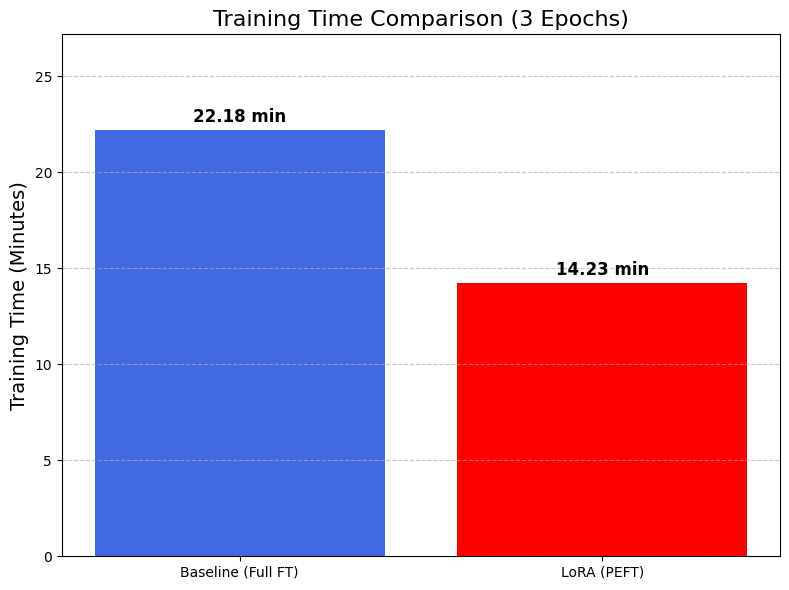

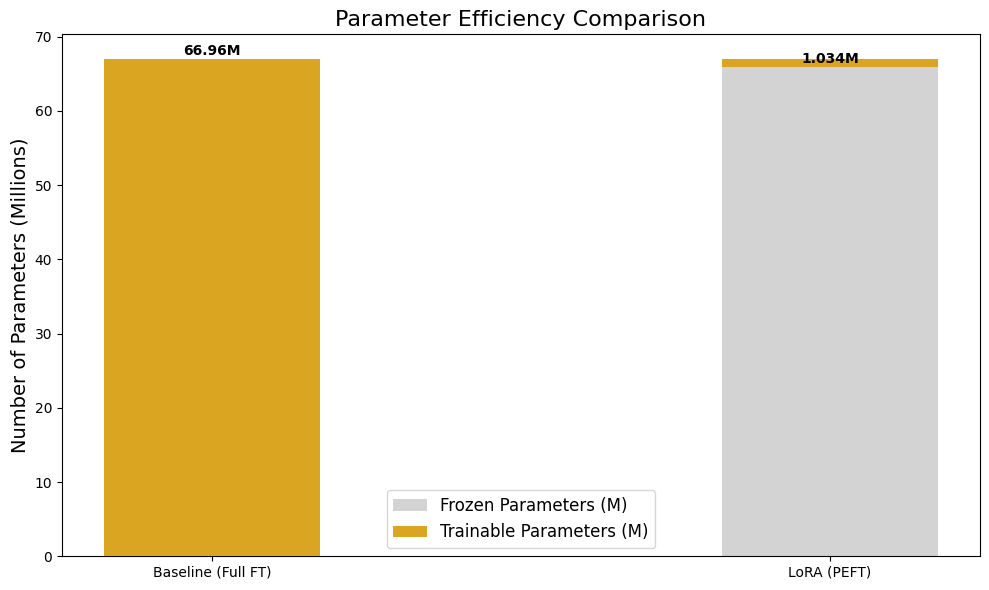

In [ ]:
def plot_parameter_comparison():
    methods = ['Baseline (Full FT)', 'LoRA (PEFT)']
    trainable_M = [BASELINE_TRAINABLE / 1e6, LORA_TRAINABLE / 1e6]
    frozen_M = [0, (TOTAL_PARAMS - LORA_TRAINABLE) / 1e6]
    x = np.arange(len(methods))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x, frozen_M, width, label='Frozen Parameters (M)', color='lightgrey', zorder=2)
    rects = ax.bar(x, trainable_M, width, bottom=frozen_M, label='Trainable Parameters (M)',
                   color='goldenrod', zorder=3)

    ax.text(rects[0].get_x() + width/2, trainable_M[0] + 0.5,
            f'{trainable_M[0]:.2f}M', ha='center', fontweight='bold')
    ax.text(rects[1].get_x() + width/2, rects[1].get_y() + rects[1].get_height()/2,
            f'{trainable_M[1]:.3f}M', ha='center', fontweight='bold')

    ax.set_title('Parameter Efficiency Comparison', fontsize=16)
    ax.set_ylabel('Number of Parameters (Millions)', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(methods)
    ax.set_yticks(np.arange(0, 80, 10))
    ax.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig("results/parameter_efficiency_comparison.png", dpi=300)
    plt.show()

if __name__ == "__main__":
    os.makedirs("results", exist_ok=True)

    print("\nEfficiency Summary")
    print(f"Baseline Time: {BASELINE_TIME_MINUTES:.2f} min | Params: {BASELINE_TRAINABLE / 1e6:.2f}M | Accuracy: {BASELINE_ACCURACY:.4f}")
    print(f"LoRA Time:     {LORA_TIME_MINUTES:.2f} min | Params: {LORA_TRAINABLE / 1e6:.3f}M | Accuracy: {LORA_ACCURACY:.4f}")
    print(f"LoRA reduced training time by: {(BASELINE_TIME_MINUTES - LORA_TIME_MINUTES):.2f} minutes")

    plot_time_comparison()
    plot_parameter_comparison()